<a href="https://colab.research.google.com/github/mindang/pytorch-master/blob/main/GAN-ResNetGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!는 한줄씩 실행되도록 !가 없으면 오류 발생
!pip3 install torch
!pip3 install torchvision

In [78]:
import torch
from torchvision import models
import numpy as np

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [80]:
netG = ResNetGenerator()

In [81]:
model_path = '/content/drive/MyDrive/pytorch-master/horse2zebra_0.4.0.pth'#모델 가중치
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [ ]:
netG.eval()

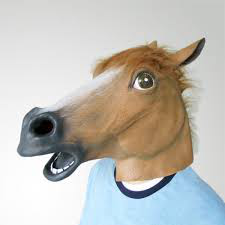

In [84]:
from PIL import Image
image = Image.open("/content/drive/MyDrive/pytorch-master/horse-mask.jpg")
image

In [85]:
from PIL import Image
from torchvision import transforms

In [86]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

In [87]:
img_t = preprocess(image)
batch_t = torch.unsqueeze(img_t, 0)

In [88]:
batch_out = netG(batch_t)

In [91]:
batch_out.shape

torch.Size([1, 3, 256, 256])

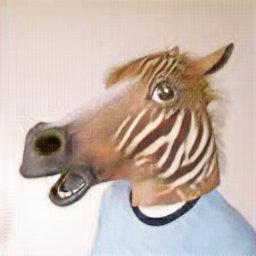

In [97]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img